In [25]:
# important important libraries

import numpy as np 
import torch 
import matplotlib.pyplot as plt 
import seaborn as sns 
from torch.utils.data import Dataset, DataLoader
import glob
from sklearn.metrics import confusion_matrix, accuracy_score
import cv2
import sys

In [92]:
class MRI(Dataset):
    def __init__(self):
        tumor = []
        no_tumor = []
        
        for f in glob.iglob("./brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img, (128,128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r , g, b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            no_tumor.append(img)
        
        for i in glob.iglob("./brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(i)
            img = cv2.resize(img, (128,128))
            b, g , r = cv2.split(img)
            img = cv2.merge([r, g , b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            tumor.append(img)
        
        # images
        tumor = np.array(tumor, dtype= np.float32)
        no_tumor = np.array(no_tumor, dtype= np.float32)
        
        # Our labels
        
        tumor_labels = np.ones(tumor.shape[0], dtype = np.float32)
        no_tumor_labels = np.zeros(no_tumor.shape[0], dtype=np.float32)
        
        
        
        self.images = np.concatenate((tumor,no_tumor), axis = 0)
        self.labels = np.concatenate((tumor_labels,no_tumor_labels))
        
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, index):
        sample = {'image' : self.images[index] , 'label' : self.labels[index]}
        return sample
    
    def normalize(self):
        self.images = self.images/255.0

In [93]:
mri = MRI()
mri.normalize()

In [94]:
mri[1]

{'image': array([[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.34509805, 0.34509805, 0.3254902 , ..., 0.00392157,
          0.00392157, 0.00392157],
         [0.        , 0.        , 0.        , ..., 0.24313726,
          0.24313726, 0.24313726],
         [0.24313726, 0.2627451 , 0.2627451 , ..., 0.34117648,
          0.34117648, 0.28235295]],
 
        [[0.28235295, 0.28235295, 0.29411766, ..., 0.00392157,
          0.00392157, 0.00392157],
         [0.        , 0.        , 0.        , ..., 0.21568628,
          0.27450982, 0.27450982],
         [0.27450982, 0.2509804 , 0.2509804 , ..., 0.3529412 ,
          0.3529412 , 0.31764707],
         ...,
         [0.24313726, 0.23921569, 0.23921569, ..., 0.2784314 ,
          0.278

### Creating dataloader

--Without dataloaders:

TypeError: Invalid shape (3, 128, 128) for image data

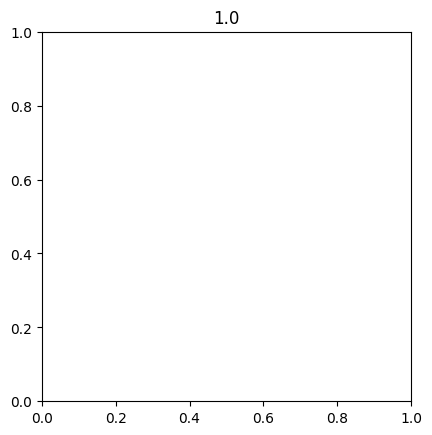

In [95]:
import random as random
index = list(range(len(mri)))
random.shuffle(index)
for idx in index:
    sample = mri[idx]
    img = sample['image']
    #print(img.shape)
    #img = img.reshape(img.shape[1],img.shape[2],img.shape[0])
    #print(img.shape)
    plt.title(sample['label'])
    plt.imshow(img)
    #plt.show()
    #break
    

torch.Size([128, 128, 3])


SystemExit: 

/Users/jihadgarti/anaconda3/envs/tensorflow/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


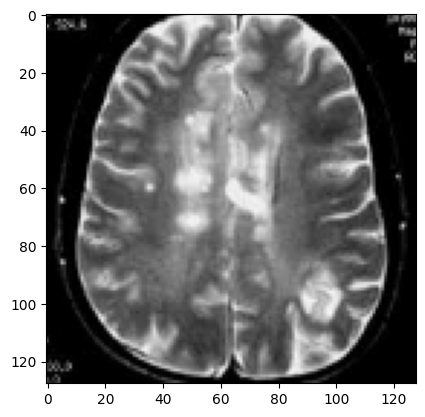

In [ ]:
dataloader = DataLoader(mri, batch_size=10 , shuffle= True)

for sample in dataloader:
    img = sample['image']
    img = img[0]
    #img = img.permute(0, 1, 2)
    print(img.shape)
    
    plt.imshow(img)
    sys.exit()
    #plt.show()

In [96]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5))
        
        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1))
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)
        
        return x
            

In [97]:
model = CNN()

In [98]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [99]:
model.cnn_model

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): Tanh()
  (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Tanh()
  (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
)

In [100]:
model.cnn_model[0].weight.shape

torch.Size([6, 3, 5, 5])

In [101]:
model.fc_model[0].weight.shape


torch.Size([120, 256])

In [102]:
!pip3 install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cpu

[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [103]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [104]:
import torch

# Check if GPU is available and set the device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Create a tensor and move it to the device
tensor = torch.rand(3, 3).to(device)

print(f"Using device: {device}")
print(f"Tensor on device: {tensor}")


Using device: mps
Tensor on device: tensor([[0.2565, 0.2536, 0.6143],
        [0.0118, 0.7115, 0.0010],
        [0.6845, 0.8332, 0.5042]], device='mps:0')


Evaluate a New-Born Neural Network!

In [105]:
mri_dataset = MRI()
mri_dataset.normalize()
device = torch.device('mps')
model = CNN().to(device)

In [109]:
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [115]:
model.eval()
outputs = []
y_true = []
with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
    


In [116]:
outputs = np.concatenate(outputs, axis=0).squeeze()
y_true = np.concatenate(y_true, axis=0).squeeze()

In [117]:
def threshold(scores, threshold = 0.50, minimum = 0,  maximum = 1):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

In [123]:
accuracy_score(y_true, threshold(outputs))

0.49707602339181284